# m.5.ASSIGNment → Spooky authorship identification via Apache Spark

### Group 6: Tyler Earps, Basil Mullings, Ryan Smith, and Ean Vandergraaf

| Overview      | Use Apache Spark and machine learning to determine sentence authorship labels. |
| ------------- | ------------------------------------------------------------------------------ |
| Data          | https://www.kaggle.com/competitions/spooky-author-identification/code          |


<figure>
    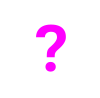
    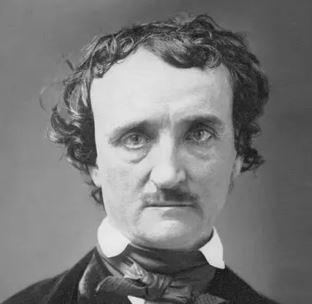
    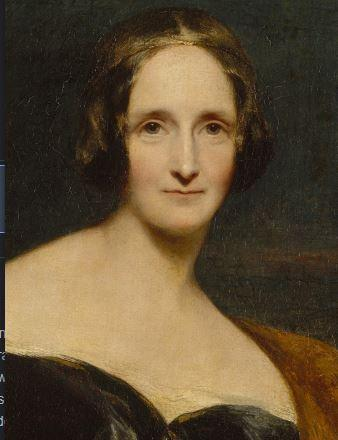
    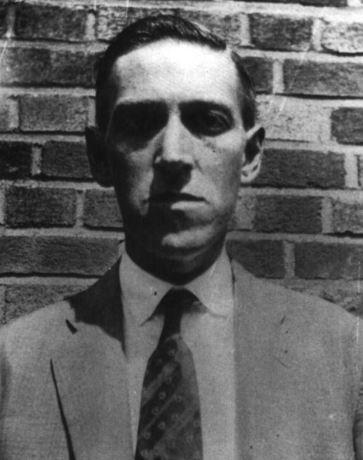
</figure>


## DETAILS

**Dataset Description**: The spooky author identification dataset contains text from works of
fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary
Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt
sentence tokenizer resulting in an odd non-sentence here and there. Your objective is to
accurately identify the author of the sentences in the test set.

- **id** - unique identifier for each sentence
- **text** - sentence written by one of the authors
- **author** - {EAP:Edgar Allan Poe}, {HPL:HP Lovecraft}; {MWS:Mary Wollstonecraft Shelley}

**Objective**:
1. Accurately identify the author of the sentences in the test set.
2. Perform ALL work using Apache Spark.

**Dataset**:
- Training consists of passages with an author label.
- Test has sentences with no author labels.

**Competition Evaluation**: The submissions were evaluated based on multi-class logarithmic loss.
The logarithmic loss assesses the uncertainty of the predicted probabilities, penalizing
confident incorrect predictions. Lower log loss values indicated better performance.

**Approach**: NLP techniques + machine learning algorithms. Feature engineering like bag-of-words,
TF-IDF, word embeddings/Word2Vec. Perform algorithmic work with logistic regression, support
vector machines, neural networks, and as appropriate.

## TASKS

### Stage 0: Import Data

1. Create a code notebook called: code_6_of_10_data_mine_<your_name>.ipynb
2. Load data into Spark data objects and explore structure, size, and distribution of information.

In [63]:
# Download the data
# If you haven't installed the Kaggle API, uncomment the line below to do so
#%pip install kaggle
#!pip install kaggle
#!kaggle competitions download -c spooky-author-identification -p data/
#!pip install wordcloud

In [64]:
# ~~~~ STAGE 0: Import Data

import zipfile
from pathlib import Path
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, countDistinct, format_number, when, col, explode, lower
import pandas as pd

# Extract the CSV files
data_path = "data"
if not Path(f"{data_path}/test.zip").is_file():
    with zipfile.ZipFile(f"{data_path}/spooky-author-identification.zip", 'r') as zipped_data:
        zipped_data.extractall(f"{data_path}/")
    with zipfile.ZipFile(f"{data_path}/train.zip", 'r') as zipped_data:
        zipped_data.extractall(f"{data_path}/")
    with zipfile.ZipFile(f"{data_path}/test.zip", 'r') as zipped_data:
        zipped_data.extractall(f"{data_path}/")

#Create a SparkSession
spark = SparkSession.builder.getOrCreate()

#Load Kaggle data into a DataFrame
df_train = spark.read.format("csv").option("header", "true").option('escape','"').load(f"{data_path}/train.csv")
df_test = spark.read.format("csv").option("header", "true").option('escape','"').load(f"{data_path}/test.csv")

# Show the data
print('#=> Train Data:')
df_train.show(5)
print("\n")

print('#=> Test Data:')
df_test.show(5)
print("\n")

#
###We'll focus on the train data for now, and will use it for most of our activities - including our train/test split.
###Later, wer'll use the test data (df_test) as our validation dataset to validate our models.
#

##Show our basic statistics
print('#=> Summary of statistics for our Training data :')
df_train.summary().show()
print("\n")

##Show the data schema
print('#=> Training data schema:')
df_train.printSchema()
print("\n")

##List the column names 
print('#=> Column names:')
print(df_train.columns)
print("\n")

##Verify any null relevant data in any of our columns.
print('#=> Training dataset with Null values:')
df_train.select([count(when(col(c).isNull(), c )).alias(c) for c in df_train.columns]).show()
print("\n")

#=> Train Data:
+-------+--------------------+------+
|     id|                text|author|
+-------+--------------------+------+
|id26305|This process, how...|   EAP|
|id17569|It never once occ...|   HPL|
|id11008|In his left hand ...|   EAP|
|id27763|How lovely is spr...|   MWS|
|id12958|Finding nothing e...|   HPL|
+-------+--------------------+------+
only showing top 5 rows



#=> Test Data:
+-------+--------------------+
|     id|                text|
+-------+--------------------+
|id02310|Still, as I urged...|
|id24541|If a fire wanted ...|
|id00134|And when they had...|
|id27757|While I was think...|
|id04081|I am not sure to ...|
+-------+--------------------+
only showing top 5 rows



#=> Summary of statistics for our Training data :


+-------+-------+--------------------+------+
|summary|     id|                text|author|
+-------+-------+--------------------+------+
|  count|  19579|               19579| 19579|
|   mean|   NULL|                NULL|  NULL|
| stddev|   NULL|                NULL|  NULL|
|    min|id00001|" Odenheimer, res...|   EAP|
|    25%|   NULL|                NULL|  NULL|
|    50%|   NULL|                NULL|  NULL|
|    75%|   NULL|                NULL|  NULL|
|    max|id27971|you could not hop...|   MWS|
+-------+-------+--------------------+------+



#=> Training data schema:
root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)



#=> Column names:
['id', 'text', 'author']


#=> Training dataset with Null values:
+---+----+------+
| id|text|author|
+---+----+------+
|  0|   0|     0|
+---+----+------+





### Stage 1: Data Preparation - Exploratory data analysis and text mining pre-processing

3. Perform exploratory data analysis and create visualizations and tables as needed.
4. Text Preprocessing: perform tasks like tokenization and stopwords removal to clean text data.
    1. Tokenize - split the text into individual words aka tokens.
    2. Remove stop.words - frequently used pronouns and personal references.
        1. Top ten include: I, you, he, she, it, we, they, me, him, her
    3. Lemmatization - convert words to their root (optional).
        1. Lemmatization is a text normalization technique that reduces words to their base or dictionary form (lemma). Use to reduce inflected or derived words to their root form for better analysis and modeling outcomes.

#=> 1.3 EDA


+-------+-------+--------------------+------+
|summary|     id|                text|author|
+-------+-------+--------------------+------+
|  count|  19579|               19579| 19579|
|   mean|   NULL|                NULL|  NULL|
| stddev|   NULL|                NULL|  NULL|
|    min|id00001|" Odenheimer, res...|   EAP|
|    max|id27971|you could not hop...|   MWS|
+-------+-------+--------------------+------+

Texts by Edgar Allan Poe: 7900 (40.3%)
Texts by H. P. Lovecraft: 5635 (28.8%)
Texts by Mary W. Shelley: 6044 (30.9%)


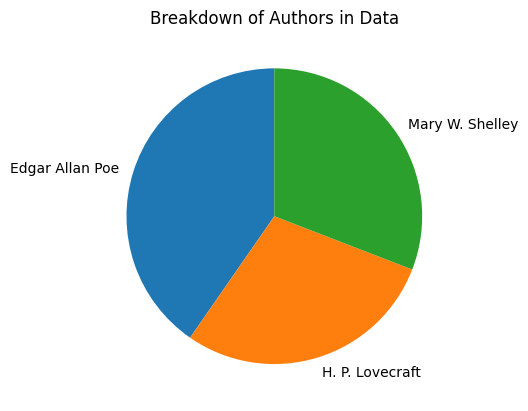

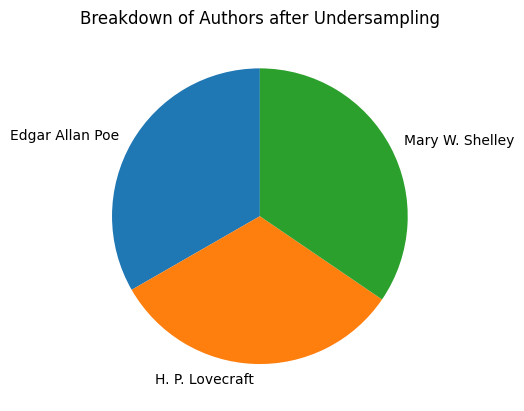


#=> 1.4.A Tokenization
Tokens: ['it', 'never', 'once', 'occurred', 'to', 'me', 'that', 'the', 'fumbling', 'might', 'be', 'a', 'mere', 'mistake']




#=> Displaying word count before stopword removal:


+---------+-----+
|each_word|count|
+---------+-----+
|      the|31473|
|       of|18546|
|      and|16504|
|       to|11612|
|        i| 9739|
+---------+-----+
only showing top 5 rows



24385
['the', 'of', 'and', 'to', 'i', 'a', 'in', 'was', 'that']

#=> 1.4.B Stopword removal
Filtered tokens: ['it', 'never', 'once', 'occurred', 'me', 'fumbling', 'might', 'be', 'mere', 'mistake']


#=> A few rows of tokenized train data:
+-------+--------------------+------+--------------------+--------------------+
|     id|                text|author|              tokens|     filtered_tokens|
+-------+--------------------+------+--------------------+--------------------+
|id17569|it never once occ...|   HPL|[it, never, once,...|[it, never, once,...|
|id27763|how lovely is spr...|   MWS|[how, lovely, is,...|[how, lovely, is,...|
|id12958|finding nothing e...|   HPL|[finding, nothing...|[finding, nothing...|
|id22965|a youth passed in...|   MWS|[a, youth, passed...|[youth, passed, s...|
|id00912|i confess that ne...|   MWS|[i, confess, that...|[confess, neither...|
|id16737|he shall find tha...|   MWS|[he, shall, find,...|[he, shall, find,...|
|id19764|herbert west need...|   HPL|[her

+---------+-----+
|each_word|count|
+---------+-----+
|       my| 4919|
|       it| 4295|
|       he| 4065|
|      had| 4062|
|     with| 3889|
+---------+-----+
only showing top 5 rows





#=> Displaying wordcloud:


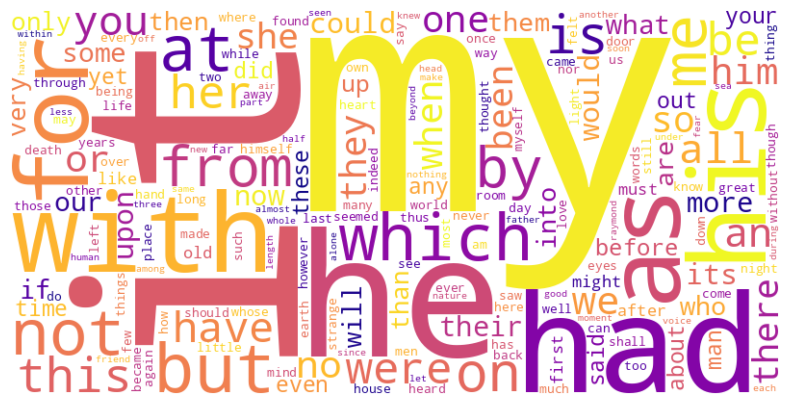

In [65]:
# ~~~~ STAGE 1: Data Preparation & EDA

from pyspark.ml.feature import StopWordsRemover, Tokenizer
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.feature import Normalizer
from pyspark.ml import Pipeline
from pyspark.sql.functions import regexp_replace
import csv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud

authors = {
    'EAP': 'Edgar Allan Poe',
    'HPL': 'H. P. Lovecraft',
    'MWS': 'Mary W. Shelley'
}

#=> 1.3 Start EDA
print('#=> 1.3 EDA')
df_train.describe().show()
eap_count = df_train.filter("author == 'EAP'").count()
hpl_count = df_train.filter("author == 'HPL'").count()
mws_count = df_train.filter("author == 'MWS'").count()
print(f"Texts by Edgar Allan Poe: {eap_count} ({round(100 * eap_count / df_train.count(), 1)}%)")
print(f"Texts by H. P. Lovecraft: {hpl_count} ({round(100 * hpl_count / df_train.count(), 1)}%)")
print(f"Texts by Mary W. Shelley: {mws_count} ({round(100 * mws_count / df_train.count(), 1)}%)")

# Breakdown of authors before undersampling
y = np.array([eap_count, hpl_count, mws_count])
labels = [authors['EAP'], authors['HPL'], authors['MWS']]
plt.title('Breakdown of Authors in Data')
plt.pie(y, labels = labels, startangle=90)
plt.show()

# Undersample majority class (EAP)
fraction = (hpl_count + mws_count) / (2 * eap_count)
undersampled_col = df_train.filter("author == 'EAP'").sample(withReplacement=False, fraction=fraction, seed=17)
df_train_undersampled = df_train.filter("author != 'EAP'").union(undersampled_col)

# Breakdown of authors after undersampling
eap_count = df_train_undersampled.filter("author == 'EAP'").count()
hpl_count = df_train_undersampled.filter("author == 'HPL'").count()
mws_count = df_train_undersampled.filter("author == 'MWS'").count()
y = np.array([eap_count, hpl_count, mws_count])
labels = [authors['EAP'], authors['HPL'], authors['MWS']]
plt.title('Breakdown of Authors after Undersampling')
plt.pie(y, labels = labels, startangle=90)
plt.show()

#=> (1.4.A) Step 1: Tokenization
# Convert the text field to lowercase, and also remove any special characters
df_train_cleaned = df_train_undersampled.withColumn("text", regexp_replace(lower(col("text")), "[^a-zA-Z0-9\\s]", ""))
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
df_train_tokenized = tokenizer.transform(df_train_cleaned)
print('\n#=> 1.4.A Tokenization')
print(f"Tokens: {df_train_tokenized.head().tokens}")
print("\n")

# Create a list of stopwords tailored to this dataset
# Explode the 'tokens' column to get individual words in separate rows
words_exploded = df_train_tokenized.withColumn("each_word", explode(col("tokens")))
##Count the occurrences of each word
word_count = words_exploded.groupBy("each_word").count()
##Now show the result
print("\n")
print('#=> Displaying word count before stopword removal:')
word_count.orderBy(col("count").desc()).show(5)

# Create and show the list of stopwords
num_stopwords = 9
stopwords_alt = [data[0] for data in word_count.orderBy(col("count").desc()).select('each_word').collect()]
print(len(stopwords_alt))
stopwords_alt = stopwords_alt[0:num_stopwords]
print(stopwords_alt)

# (1.4.B) Step 2: Stopword removal
# List of stopwords compiled from the Gigaword corpus by Dr. George Wilson of Georgetown University: https://faculty.georgetown.edu/wilsong/IR/WD3.html
with open('stopwords.csv', newline='') as csvfile:
    stopword_reader = csv.reader(csvfile, delimiter=',')
    next(stopword_reader, None)  # Skip header
    stopwords = [row[2] for row in stopword_reader]
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens", stopWords=stopwords_alt)
df_train_no_stopwords = stopwords_remover.transform(df_train_tokenized)
print('\n#=> 1.4.B Stopword removal')
print(f"Filtered tokens: {df_train_no_stopwords.head().filtered_tokens}")

# Some more EDA
##List a few rows from our now tokenized train dataa
print("\n")
print('#=> A few rows of tokenized train data:')
df_train_no_stopwords.show(10)

##Explode the 'filtered_tokens' column to get individual words in separate rows
words_exploded = df_train_no_stopwords.withColumn("each_word", explode(col("filtered_tokens")))

##Count the occurrences of each word
word_count = words_exploded.groupBy("each_word").count()

##Now show the result
print("\n")
print('#=> Displaying word count after stopword removal:')
word_count.orderBy(col("count").desc()).show(5)

##Create a wordcloud from the word counts obtained.
##Convert the PySpark DataFrame to Pandas DataFrame
df_word_count_pd = word_count.toPandas()

##Convert the Pandas DataFrame to a dictionary of word counts
word_freq_dict = dict(zip(df_word_count_pd['each_word'], df_word_count_pd['count']))

##Now create and display the word cloud
print("\n")
print('#=> Displaying wordcloud:')

##Now create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap = 'plasma').generate_from_frequencies(word_freq_dict)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


#### Summary of Stage 1 Findings

In stage 1, we got familiar with the data by performing some basic EDA. From the graph <b>Breakdown of Authors in Data</b>, it appears as though all authors are represented evenly throughout the data. Additionally, we started preparing the data by performing `Tokenization` and `Stopword Removal`. Once data preperation was complete we followed up with some more EDA. In our word cloud, it looks like the word "<b>upon</b>" appears the most in our filtered dataset.

### Stage 2: Feature Extraction

5. Perform TF-IDF to quantify word importance <[term.frequency.inverse.doc.frequency](https://en.wikipedia.org/wiki/Tf–idf)>
6. Normalize is scaling or standardizing the numerical features to a standard range or distribution.
    1. In text mining, normalization vectorizes features with methods like TF-IDF, a numerical
measurement, to ensure a consistent scale.
    2. It handles variations in the magnitude of feature values impacting machine-learning algorithm
performance. Normalize the features to ensure a similar scale and prevent features with larger
values from dominating the analysis or modeling process.

In [66]:
# ~~~~ STAGE 2: Feature extraction, including TF-IDF calculation

from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, StringIndexer, CountVectorizerModel

#Convert words to vectors of token counts. 
count_vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="vectorized_tokens", minDF=2)

# (2.5) TF-IDF frequency scores regarding the importance of words.
idf = IDF(inputCol="vectorized_tokens", outputCol="tfidf")

# (2.6) Normalize the tfidf scores.
normalizer = Normalizer(inputCol="tfidf", outputCol="normalized")

##Convert authors names to numerical labels
indexer = StringIndexer(inputCol="author", outputCol="label")

##Create a pipeline to be used later when training the ML. 
pipeline = Pipeline(stages=[count_vectorizer, idf, normalizer, indexer])

##Fit the pipeline and transform the training dataset
pipeline_model = pipeline.fit(df_train_no_stopwords)
train_processed_data = pipeline_model.transform(df_train_no_stopwords)

##Now display 2 rows of the processed train data.
print("\n")
print('#=> Displaying processed train data:')
train_processed_data.show(n=2, truncate=False)




#=> Displaying processed train data:
+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------

### Stage 3: Machine Learning

7. Perform train/test split.
8. Perform algorithmic analysis to assess and predict test labels.
    1. Use as many algorithms as you need to get a good answer.
    2. Supervised: logistic regression, random forest, support vector machines, etc.
    3. Unsupervised: K-means, dimensionality reduction, PCA, etc.

In [67]:
# ~~~~ STAGE 3 - Machine Learning.
#
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes

#=> Stage 3.7 - Perform our train/test split
##Split the training data into training and test sets (80% training, 20% test)
X_train, X_test = train_processed_data.randomSplit([0.8, 0.2], seed=42)

##Our list of ML models
ml_models = {
    # "randomForest_model": RandomForestClassifier(featuresCol="normalized", labelCol="label"),
    # "decisionTree_model": DecisionTreeClassifier(featuresCol="normalized", labelCol="label"),
    "logisticReg_model": LogisticRegression(featuresCol="normalized", labelCol="label"),
    "naive_bayes_model": NaiveBayes(featuresCol="normalized", labelCol="label")
}

##Catalog the "author" prediction results of our models.
results = {}
for model_name, model in ml_models.items():
    ##Proceed to train the model.
    trained_model = model.fit(X_train)

    ##Do the prediction
    y_pred = trained_model.transform(X_test)

    #=> Stage 3.8
    ##Do the evaluation.
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(y_pred)
    results[model_name] = { "accuracy": accuracy, "y_pred": y_pred }
    print(f"{model_name}: {accuracy=}")

    ##Check the predictions.
    y_pred.select("label", "prediction").show(5)

highest_accuracy = 0
best_performing_model = ""

##Now traverse our results dictionary and find the highest accuracy of each of our model.
for model_name, result in results.items():
    if result["accuracy"] > highest_accuracy:
        highest_accuracy = result["accuracy"]
        best_model = model_name

print(f'The Best performing model: {best_model}={highest_accuracy}')


logisticReg_model: accuracy=0.7286049237983587


+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       2.0|
|  0.0|       0.0|
|  2.0|       2.0|
|  2.0|       2.0|
|  2.0|       1.0|
+-----+----------+
only showing top 5 rows



naive_bayes_model: accuracy=0.8423212192262602


+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  2.0|       2.0|
|  2.0|       2.0|
|  2.0|       1.0|
+-----+----------+
only showing top 5 rows

The Best performing model: naive_bayes_model=0.8423212192262602


#### Summary of Stage 3 Findings

In stage 3, we selected our 4 algorithms that we want to analyze:
* Random Forest Classifier
* Decision Tree
* Logistic Regression
* Naive Bayes

We trained each model on the training data, made predictions based on the testing data, and did an initial accuracy test against each. Based upon our intial accuracy test, the model with the best performance is `Naive Bayes`.

### Stage 4: Evaluation & Visualization

9. Choose a metric strategy to assess algorithmic performance like accuracy, precision, recall, or F1 score.
10. Visualize confusion matrix, correlations, and similar.
11. Identify important features contributing to classification.
12. Write a 2-3 sentence minimum of findings, learnings, and what you would do next.

#=> 4.9 & 4.10
~~~~~~~
Evaluating  logisticReg_model ...


Accuracy:  0.7286049237983587


Precision:  0.7285914493701533


Recall:  0.7286049237983587


F1 Score:  0.728595784492478 



Confusion Matrix:


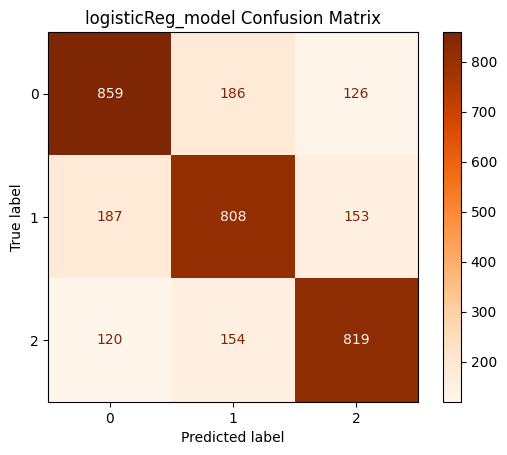

~~~~~~~
Evaluating  naive_bayes_model ...


Accuracy:  0.8423212192262602


Precision:  0.8467452417975739


Recall:  0.8423212192262602


F1 Score:  0.8419121045263289 



Confusion Matrix:


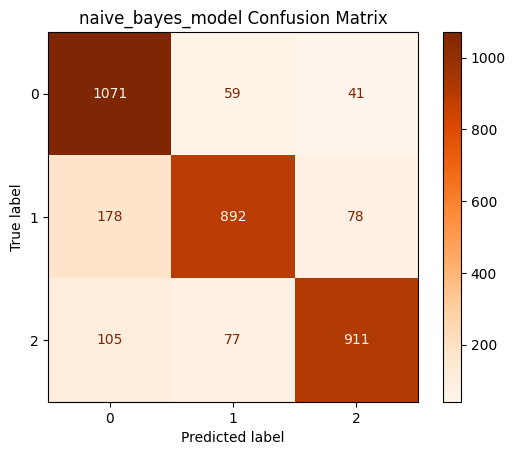



#=> Displaying confusion matrix:


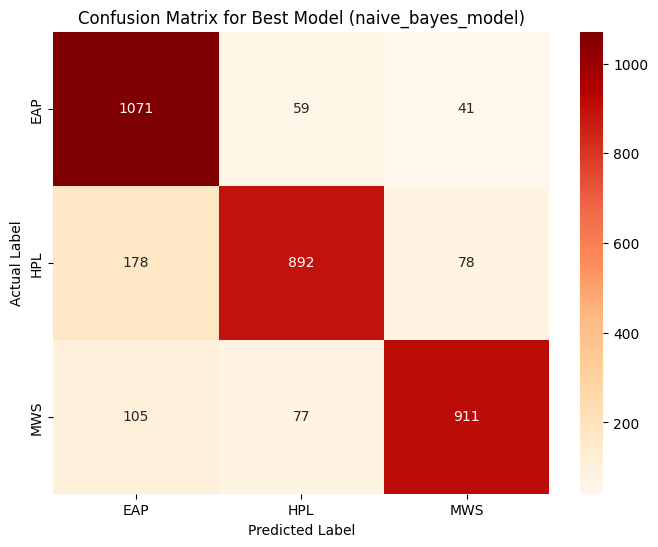

In [68]:
# ~~~~ STAGE 4 - Evaluation & Visualization.
#Stage 4.9 - Going through 4 algorithms from stage 3.
import sklearn 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
import pandas as pd
import seaborn as sns

evalScores = {}
accuracies = []
precisions = []
recalls = []
f1s = []
print('#=> 4.9 & 4.10')
for model_name, model in ml_models.items():
    #=> 4.9 Evaluation
    
    print("~~~~~~~")
    print("Evaluating ", model_name, "...")

    #Train
    trained_model = model.fit(X_train)
    #Predictions
    prediction = trained_model.transform(X_test)

    #Evaluation
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    
    accuracy = evaluator.setMetricName("accuracy").evaluate(prediction)
    print("Accuracy: ", accuracy)
    
    precision = evaluator.setMetricName("weightedPrecision").evaluate(prediction)
    print("Precision: ", precision)

    recall = evaluator.setMetricName("weightedRecall").evaluate(prediction)
    print("Recall: ", recall)

    f1 = evaluator.setMetricName("f1").evaluate(prediction)
    print("F1 Score: ", f1, "\n")

    yTrue = prediction.select(['label']).collect()
    yPred = prediction.select(['prediction']).collect()

    print("Confusion Matrix:")
    confusion = confusion_matrix(yTrue, yPred)

    #=> 4.10 Visualization
    confusion_plot = ConfusionMatrixDisplay(confusion_matrix=confusion)
    confusion_plot.plot(cmap=plt.cm.Oranges)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    if model_name == 'randomForest_model':
        #=> 4.11 Random Forest is good at selecting Feature Importance
        print('#=> 4.11 Feature Importance')
        
        # Grab vocabulary from the pipeline 
        vectorizers = [stage for stage in pipeline_model.stages if isinstance(stage, CountVectorizerModel)]
        vocabulary = [v.vocabulary for v in vectorizers]
        names = vocabulary[0]
        
        # Grab feature importances
        importances = trained_model.featureImportances.toArray().tolist()

        # Transform to dataframe so we can display information
        features_importances_df = spark.createDataFrame(list(zip(names, importances)), ["feature", "importance"])
        top_features_df = features_importances_df.orderBy(features_importances_df.importance.desc()).limit(20)
        
        plt.figure(figsize=(10, 6))
        plt.bar(top_features_df.select("feature").rdd.flatMap(lambda x: x).collect(), top_features_df.select("importance").rdd.flatMap(lambda x: x).collect(), color='orange')
        plt.xlabel("Feature")
        plt.xticks(rotation=90)
        plt.title("Top 20 Features")
        plt.show()
        plt.show()
    elif model_name == 'decisionTree_model':
        # Display the tree (in text form)
        tree = trained_model.toDebugString
        print('\nTree Visualization:')
        print(tree)

    #Gathering data for evaluation in next cell
    evalScores[model_name] = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

##Will show a confusion matrix for our best fitted model.
y_pred = results[best_model]["y_pred"]
y_pred.groupBy("label", "prediction").count()

##Create the confusion matrix
conf_matrix = y_pred.groupBy("label", "prediction").count().toPandas().pivot(index='label', columns='prediction', values='count')

##Now Plot & display the confusion matrix
##Now display confusion matrix for our best model.
print("\n")
print('#=> Displaying confusion matrix:')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="OrRd", cbar=True, 
            xticklabels=['EAP', 'HPL', 'MWS'],
            yticklabels=['EAP', 'HPL', 'MWS'])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title(f"Confusion Matrix for Best Model ({best_model})")
plt.show()

The best model with accuracy score is naive_bayes_model with a score of: 0.8423212192262602
The best model with precision score is naive_bayes_model with a score of: 0.8467452417975739


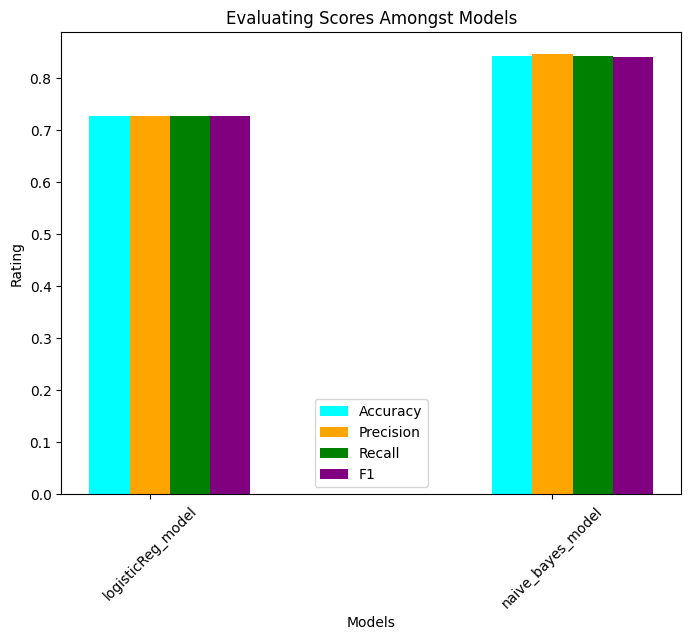

In [69]:
#=> Continuation of 4.10

# highest = [0,0,0,0]
# topModelScores = ["","","",""]
highest = [0,0]
topModelScores = ["",""]

for modelName, evalScore in evalScores.items():
    if evalScore["accuracy"] > highest[0]:
        highest[0] = evalScore["accuracy"]
        topModelScores[0] = modelName
        
        
    if evalScore["precision"] > highest[1]:
        highest[1] = evalScore["precision"]
        topModelScores[1] = modelName
        

    # if evalScore["recall"] >  highest[2]:
    #     highest[2] = evalScore["recall"]
    #     topModelScores[2] = modelName
        

    # if evalScore["f1"] > highest[3]:
    #     highest[3] = evalScore["f1"]
    #     topModelScores[3] = modelName
        
print("The best model with accuracy score is", topModelScores[0], "with a score of:",  highest[0])
print("The best model with precision score is", topModelScores[1], "with a score of:",  highest[1])
# print("The best model with recall score is", topModelScores[2], "with a score of:",  highest[2])
# print("The best model with f1 score is", topModelScores[3], "with a score of:",  highest[3])

# => Print Models against Scores
# x = np.arange(4)
x = np.arange(2)
width = 0.1
plt.figure(figsize=(8,6))
plt.title('Evaluating Scores Amongst Models')
plt.bar(x-width, accuracies, width, color='cyan') 
plt.bar(x, precisions, width, color='orange') 
plt.bar(x+width, recalls, width, color='green') 
plt.bar(x+width*2, f1s, width, color='purple') 
plt.xticks(x, list(evalScores.keys()), rotation=45) 
plt.xlabel("Models") 
plt.ylabel("Rating") 
plt.legend(['Accuracy', 'Precision', 'Recall', 'F1']) 
plt.show()

#### Summary of Stage 4 Findings (4.12)

We decided to analyze four different machine learning algorithms (`Random Forest`, `Decision Tree`, `Logistic Regression`, and `Naive Bayes`). Furthermore, we decided to evaluate the algorithms using four different methods (`Accuracy`, `Precision`, `Recall`, and `F1 Scores`). Based upon the graph <b>Evaluating Scores Amongst Models</b>, `Naive Bayes` scored the best on average across all of the alogrithms and evaluation methods. On average it scored around 80%. Even though we already have a fairly good score with our `Naive Bayes` model, it would be a good idea to keep fine tuning the parameters in an attempt to continue raising that score.

##### Additional Resources Used
* [Extract Vocabulary from Pipeline](https://stackoverflow.com/questions/46715559/how-to-extract-vocabulary-from-pipeline)
* [How to Create Confusion Matrix](https://stackoverflow.com/questions/58404845/confusion-matrix-to-get-precsion-recall-f1score)
* [Converting PySpark DataFrame Column to List: A Guide](https://saturncloud.io/blog/converting-pyspark-dataframe-column-to-list-a-comprehensive-guide/#:~:text=Method%201%3A%20Using%20collect()&text=We%20can%20use%20the%20collect()%20function%20to%20achieve%20this.&text=The%20select()%20function%20is,elements%20for%20each%20input%20element.]

    1. Tokenizer to split part of the pyspark.ml.feature module
    2. StopWordsRemover in the pyspark.ml.feature module.
    3. lemmatization - PySpark does not have a built-in lemmatization use User-Defined
    Functions UDF to create.
    4. normalize like convert text to lowercase; remove special characters with PySpark user
    defined functions <UDF> or built-in string functions like lower() or regexp_replace().
    5. tf.idf PySpark's CountVectorizer and IDF class compute tf.idf for text feature
    extraction.

#### Resources
- [How to Assess Algorithm Fit](https://github.com/cosc-526/home.page/blob/86eac9b60052cdb5959c0e9fa96b7e7f3a3fcdd9/how.To.M.5.algorithm.Assess.fit.super.unsuper.pdf)
- [PySpark Code Dictionary](https://github.com/cosc-526/home.page/blob/2d9505d38a2b76ce61991fc59223f511aef34472/reference.library.pyspark.code.dictionary.pdf)
- [pd.DataFrame vs. rdd.DataFrame](https://github.com/cosc-526/home.page/blob/c7bc526297dc72517a270df22d4f8109c8cae149/cheatsheet.pyspark.RDD.feng.utk.pdf)
- [Cheat Sheet for PySpark](https://github.com/cosc-526/home.page/blob/c7bc526297dc72517a270df22d4f8109c8cae149/cheatsheet.pyspark.feng.utk.pdf)
- [Additional PySpark Guide](https://github.com/cosc-526/home.page/blob/c7bc526297dc72517a270df22d4f8109c8cae149/cheatsheet.python.feng.utk.pdf)
- [Cheat Sheet for LaTeX](https://github.com/cosc-526/home.page/blob/c7bc526297dc72517a270df22d4f8109c8cae149/cheatsheet.LaTeX.feng.utk.pdf)
- [Apache Spark Source Documentation](https://spark.apache.org/docs/latest/index.html)
- Feng, W. (2021). [Learning Apache Spark with Python](https://runawayhorse001.github.io/LearningApacheSpark/pyspark.pdf). GitHub.

#### Additional Resources
- Feng, W., & Chen, M. (2017). [Learning Apache Spark](https://mingchen0919.github.io/learning-apache-spark/index.html). GitHub.
- Karau, H., Konwinski, A., Wendell, P., & Zaharia, M. (2015). Learning Spark: Lightning-fast
big data analysis. O’Reilly Media, Inc.
- Kirillov, A. (2016). [Apache Spark: Core concepts, architecture and internals](http://datastrophic.io/core-concepts-architecture-and-internals-of-apache-spark/).
Datastrophic.
